In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install pandas
!pip install matplotlib.pyplot
!pip install pm4py

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=61d27d23552516c31dc6af5bf509908c67f13ff627f55805e840f2f0e6a4f8b2
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pm4py
from scipy.stats import shapiro
import scipy.stats as stats

In [ ]:
event_logs = pd.read_csv('/content/drive/MyDrive/BIS/Logs.csv', sep=',')

In [ ]:
event_logs['time:timestamp'] = pd.to_datetime(event_logs['time:timestamp'])

In [ ]:
event_logs.drop(columns=['org:resource', 'vehicleClass', 'lifecycle:transition', 'notificationType', 'lastSent', 'matricola', 'totalPaymentAmount', 'points'], inplace=True, axis=1)

In [ ]:
# Calculate the duration of each case
case_durations = event_logs.groupby('case:concept:name').agg(Duration=('time:timestamp', lambda x: (x.max() - x.min()).days))

filter = case_durations[case_durations['Duration'] > 0]
event_logs = event_logs[event_logs['case:concept:name'].isin(filter.index)]

# Print the number of unique active cases with a duration greater than zero
print('Number of active cases: {}'.format(len(event_logs['case:concept:name'].unique().tolist())))

Number of active cases: 145450


In [ ]:
# Function to create a unified "amount" column based on the activity type in each row
def format_amounts(row):
    if row['concept:name'] == 'Create Fine':
        return row['amount']
    elif row['concept:name'] == 'Send Fine':
        return row['expense']
    elif row['concept:name'] == 'Add penalty':
        return row['amount']
    elif row['concept:name'] == 'Payment':
        return row['paymentAmount']
    else:
        return 0

event_logs['amount'] = event_logs.apply(format_amounts, axis=1)
event_logs.drop(columns=['expense', 'paymentAmount'], inplace=True, axis=1)

In [ ]:
# Function to determine if a case is dismissed based on the 'dismissal'
def format_dismiss(row):
    if row['dismissal'] in ['#', 'G']:
        return 'Yes'
    elif row['dismissal'] == 'NIL':
        return 'No'
    elif pd.isna(row['dismissal']):
        return 'No'
    else:
        return 'Unknown'

event_logs['dismissal'] = event_logs.apply(format_dismiss, axis=1)

unknown_dismissal = event_logs[event_logs['dismissal'].isin(['Unknown'])]['case:concept:name'].unique()
event_logs = event_logs[~event_logs['case:concept:name'].isin(unknown_dismissal.tolist())]

In [ ]:
event_logs_csv = event_logs.fillna(0)

In [ ]:
# Get all the activities before Payment
issued = event_logs[event_logs['concept:name'] != 'Payment']
# Sum issued amount of each activity
issued_amounts = issued.groupby('case:concept:name')['amount'].sum().reset_index()
issued_amounts.columns = ['case:concept:name', 'issuedAmount']

# Filter and group paid amounts
paid = event_logs[event_logs['concept:name'] == 'Payment']
# Sum paid amount for each case
paid_amounts = paid.groupby('case:concept:name')['amount'].sum().reset_index()
paid_amounts.columns = ['case:concept:name', 'paidAmount']

# Join the Dataframes on case
merged_amounts = issued_amounts.set_index('case:concept:name').join(
    paid_amounts.set_index('case:concept:name'), how='left'
)

merged_amounts.reset_index(inplace=True)
# Fill NaN values in with zero
merged_amounts['paidAmount'] = merged_amounts['paidAmount'].fillna(0).astype(np.int32)

# Retain only cases where the issued and paid amounts match exactly (excluding cases with both amounts as 0).
compare_amounts = merged_amounts[
    (merged_amounts['issuedAmount'] == merged_amounts['paidAmount']) & (merged_amounts['issuedAmount'] != 0)
]

# Dataset of paid cases
paid_cases = event_logs[event_logs['case:concept:name'].isin(compare_amounts['case:concept:name'].tolist())]
print('Number of conformant cases: {}'.format(len(event_logs['case:concept:name'].unique().tolist())))


Number of conformant cases: 144949


In [ ]:
# Retrieve and print the start and end activities of the conformant event logs

start_activities = pm4py.get_start_activities(paid_cases)
end_activities = pm4py.get_end_activities(paid_cases)

print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'Create Fine': 31842}
End activities: {'Payment': 31833, 'Send Fine': 8, 'Send Appeal to Prefecture': 1}


In [ ]:
# Filter out cases where the last recorded activity is not a payment

# Identify the last activity for each case
last_activities = paid_cases.sort_values(by=['case:concept:name', 'time:timestamp']).groupby('case:concept:name').last().reset_index()

# Removes cases that do not end with a payment
to_remove_cases = last_activities[last_activities['concept:name'] != 'Payment']['case:concept:name']

# Update the dataset to include only conformant cases
paid_cases = paid_cases[~paid_cases['case:concept:name'].isin(to_remove_cases)]

print('Number of conformant cases: {}'.format(len(paid_cases['case:concept:name'].unique().tolist()))) # Prints the number of remaining conformant cases

Number of conformant cases: 31833


In [ ]:
# Retrieve the variants of the conformant event logs, creates a DataFrame from the variants dictionary
variants = pm4py.get_variants(paid_cases)

variants_df = pd.DataFrame.from_dict(variants, orient='index', columns=['Count'])
variants_df = variants_df.reset_index()

variants_df = variants_df.rename(columns={'index': 'Variant'})
variants_df = variants_df.sort_values(by=['Count'], ascending=False)
variants_df = variants_df.reset_index(drop=True)

variants_df

,Variant,Count
0,"(Create Fine, Payment)",30436
1,"(Create Fine, Send Fine, Payment)",1360
2,"(Create Fine, Payment, Send Fine, Payment)",18
3,"(Create Fine, Send Fine, Payment, Payment)",12
4,"(Create Fine, Send Fine, Insert Fine Notificat...",3
5,"(Create Fine, Send Fine, Insert Date Appeal to...",2
6,"(Create Fine, Payment, Payment)",1
7,"(Create Fine, Send Fine, Insert Fine Notificat...",1


In [ ]:
# STATISTICAL PROPERTY
# Difference (days) from Fine Creation to Send Fine activities

# Retrieve only the two activities "Create Fine" and "Send Fine"
filter = paid_cases[paid_cases['concept:name'].isin(['Create Fine', 'Send Fine'])]

# Pivot 'Create Fine' and 'Send Fine' activities
pivot = filter.pivot_table(index='case:concept:name', columns='concept:name', values='time:timestamp', aggfunc='min').reset_index()
pivot = pivot.rename(columns={"Create Fine": "Create_Fine_Time", "Send Fine": "Send_Fine_Time"})

pivot['Days'] = (pivot['Send_Fine_Time'] - pivot['Create_Fine_Time']).dt.days
pivot = pivot.dropna(subset=['Create_Fine_Time', 'Send_Fine_Time'])

pivot

concept:name,case:concept:name,Create_Fine_Time,Send_Fine_Time,Days
77,A10435,2007-07-01,2007-09-29,90.0
78,A1045,2006-12-11,2007-04-05,115.0
98,A10561,2007-03-26,2007-08-02,129.0
196,A11029,2007-04-25,2007-08-02,99.0
241,A11246,2007-03-28,2007-08-02,127.0
...,...,...,...,...
31828,V9902,2002-09-03,2002-10-25,52.0
31829,V9920,2002-09-04,2002-10-25,51.0
31830,V9927,2002-09-05,2002-10-25,50.0
31831,V9930,2002-09-05,2002-10-25,50.0


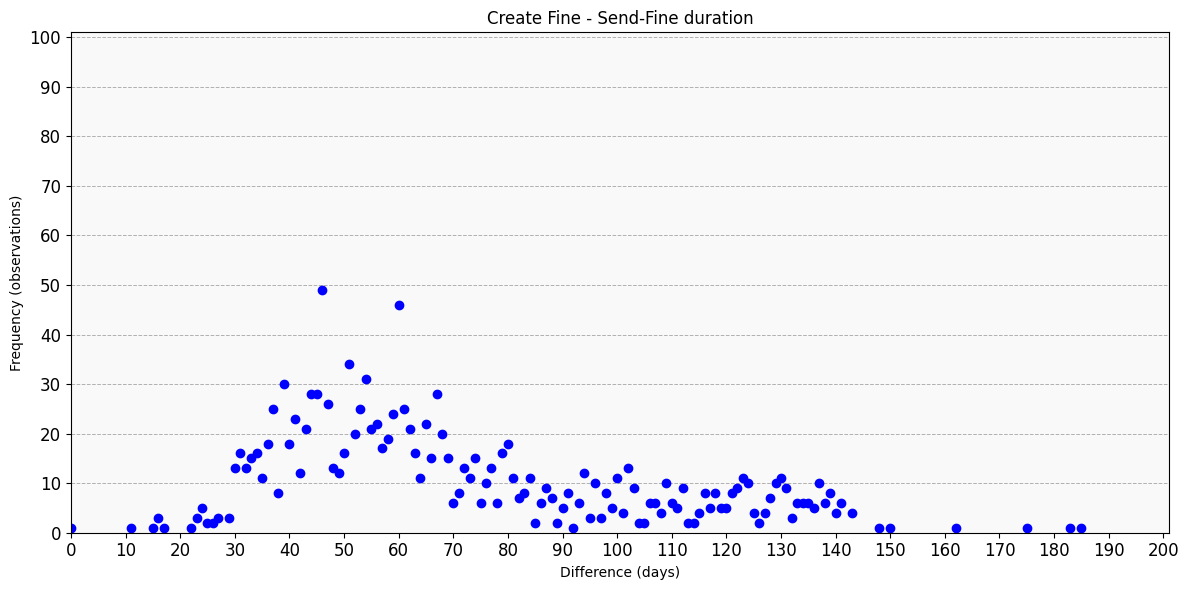

Mean of the differences: 69.91117478510029
Median of the differences: 61.0
Sample Standard Deviation: 31.142049224053494


In [ ]:
# Calculate frequency of durations
frequency = pivot.groupby('Days').size().reset_index(name='Count')

# Define graph
plt.figure(figsize=(12, 6))
plt.plot(frequency['Days'], frequency['Count'], 'o', color='blue')

# Set labels and title
plt.xlabel('Difference (days)')
plt.ylabel('Frequency (observations)')
plt.title('Create Fine - Send-Fine duration')

# Set axis limits
plt.xlim(0, 201)
plt.ylim(0, 101)

# Add more labels on the axis
plt.xticks(np.arange(0, 201, 10), fontsize=12)
plt.yticks(np.arange(0, 101, 10), fontsize=12)
plt.yticks(fontsize=12)

# More style
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.gca().set_facecolor('#f9f9f9')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

mean_difference = pivot['Days'].mean()
print(f"Mean of the differences: {mean_difference}")

median_difference = pivot['Days'].median()
print(f"Median of the differences: {median_difference}")

# Calculate standard deviation
std_deviation = np.std(pivot['Days'], ddof=1)
print("Sample Standard Deviation:", std_deviation)


# The right side of the distribution appears to be slightly elevated indicating a right skew.
# This means that there are some larger difference values that occur less frequently, but more than what a perfectly symmetrical distribution would show.
# This is indicative of a positive skew, where the mean is typically greater than the median.
# The presence of outliers or higher values on the right side pulls the mean towards the higher end

In [ ]:
# Test for normality using Shapiro-Wilk
shapiro_test = stats.shapiro(frequency['Days'])
print('Shapiro-Wilk Test P-Value:', shapiro_test.pvalue)

# Test for normality using Jarque-Bera
jarque_bera_test = stats.jarque_bera(frequency['Days'])
print('Jarque-Bera Test P-Value:', jarque_bera_test.pvalue)

# If P-Value > 0.05, we fail to reject the null hypothesis, meaning data is likely normal
if shapiro_test.pvalue > 0.05 and jarque_bera_test.pvalue > 0.05:
    print("There is not enough evidence to reject the null hypothesis that the data is normally distributed.")
else:
    print("The data is not normally distributed.")

#  Given that both the Shapiro-Wilk and Jarque-Bera tests have p-values greater than 0.05
# We do not reject the null hypothesis that your data is normally distributed.
# This suggests that it is reasonable to assume that the Difference data follows a normal distribution.


Shapiro-Wilk Test P-Value: 0.0719853863120079
Jarque-Bera Test P-Value: 0.1969621165468974
There is not enough evidence to reject the null hypothesis that the data is normally distributed.


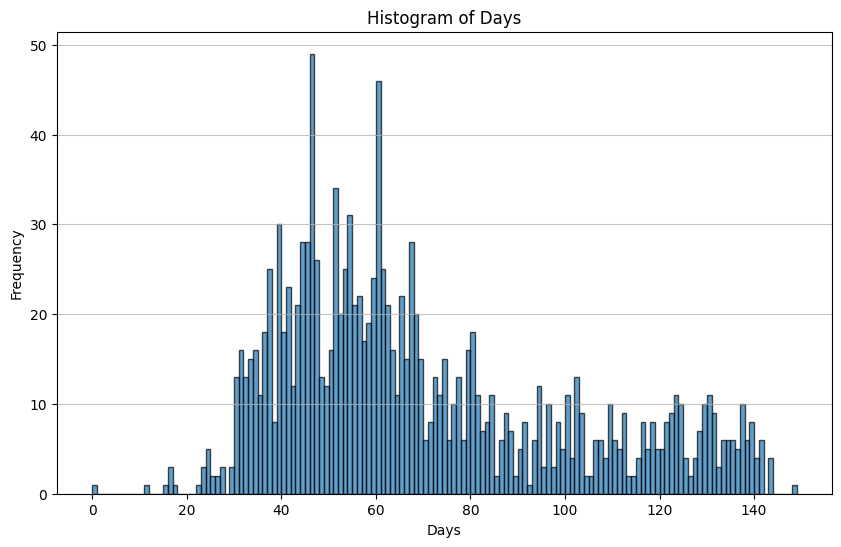

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(pivot['Days'], bins=range(0, 150), edgecolor='black', alpha=0.7)
plt.title('Days')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [ ]:
# Calculate the sample mean and standard error
mean_difference = pivot['Days'].mean()
std_dev_difference = pivot['Days'].std()
n = pivot.shape[0]
sem = std_dev_difference / (n**0.5)

# Calculate the 95% confidence interval
confidence_level = 0.95
degrees_freedom = n - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, mean_difference, sem)

print(f"Mean of the differences: {mean_difference}")
print(f"95% confidence interval for the mean difference: {confidence_interval}")

Mean of the differences: 69.91117478510029
95% confidence interval for the mean difference: (68.27613042451182, 71.54621914568875)


In [ ]:
# STATISTICAL PROPERTY
# Time from Create Fine to Payment

# Filter for events with "Create Fine" and "Send Fine"
filter_2 = paid_cases[paid_cases['concept:name'].isin(['Create Fine', 'Payment'])]

# Pivot 'Create Fine' and 'Send Fine' activities
pivot_2 = filter_2.pivot_table(index='case:concept:name', columns='concept:name', values='time:timestamp', aggfunc='min').reset_index()
pivot_2 = pivot_2.rename(columns={"Create Fine": "Create_Fine_Time", "Payment": "Payment_Time"})

pivot_2['Days'] = (pivot_2['Payment_Time'] - pivot_2['Create_Fine_Time']).dt.days
pivot_2 = pivot_2.dropna(subset=['Create_Fine_Time', 'Payment_Time'])

pivot_2

concept:name,case:concept:name,Create_Fine_Time,Payment_Time,Days
0,A10005,2007-03-20,2007-03-21,1
1,A10007,2007-03-20,2007-03-23,3
2,A10022,2007-03-22,2007-03-28,6
3,A10024,2007-03-22,2007-03-26,4
4,A10029,2007-03-22,2007-04-10,19
...,...,...,...,...
31828,V9902,2002-09-03,2002-11-05,63
31829,V9920,2002-09-04,2002-11-04,61
31830,V9927,2002-09-05,2002-11-04,60
31831,V9930,2002-09-05,2002-11-18,74


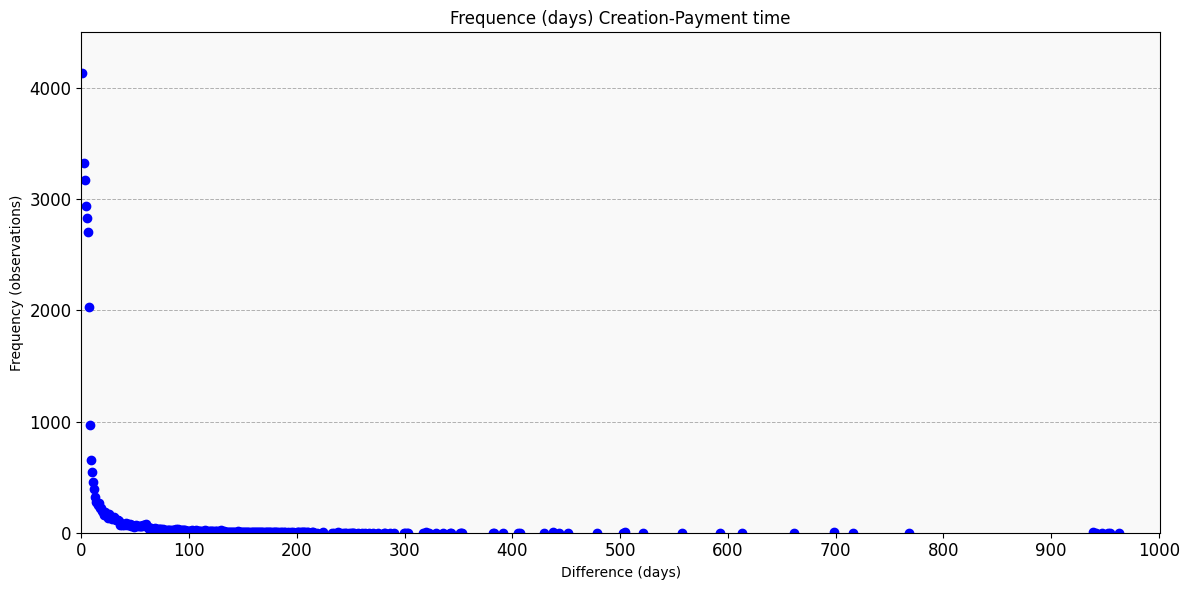

Mean of the differences: 15.933747997361229
Median of the differences: 5.0
Sample Standard Deviation: 38.99638118457645


In [ ]:
frequency_2 = pivot_2.groupby('Days').size().reset_index(name='Count') # Calculate frequency of durations

frequency_2.to_csv('payment_time.csv')

# Define graph
plt.figure(figsize=(12, 6))
plt.plot(frequency_2['Days'], frequency_2['Count'], 'o', color='blue')


# Set labels and title
plt.xlabel('Difference (days)')
plt.ylabel('Frequency (observations)')
plt.title('Frequence (days) Creation-Payment time')

# Set axis limits
plt.xlim(0, 1001)
plt.ylim(0, 4501)

# Add more labels on the axis
plt.xticks(np.arange(0,1001, 100), fontsize=12)
plt.yticks(np.arange(0, 4501, 1000), fontsize=12)
plt.yticks(fontsize=12)

# More style
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.gca().set_facecolor('#f9f9f9')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


mean_difference = pivot_2['Days'].mean()
print(f"Mean of the differences: {mean_difference}")

median_difference = pivot_2['Days'].median()
print(f"Median of the differences: {median_difference}")

std_deviation = np.std(pivot_2['Days'], ddof=1)
print("Sample Standard Deviation:", std_deviation)

In [ ]:
# Number of bootstrap samples
B = 10000
n = len(pivot_2['Days'])
bootstrap_means = np.zeros(B)

# Generate bootstrap samples and compute the statistic
for i in range(B):
    bootstrap_sample = np.random.choice(pivot_2['Days'], size=n, replace=True)
    bootstrap_means[i] = np.mean(bootstrap_sample)

# Compute confidence intervals
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

print("Bootstrap 95% CI for the mean:", (lower_bound, upper_bound))

Bootstrap 95% CI for the mean: (15.510503251342946, 16.358576006031477)


In [ ]:
filtered_log = pm4py.filter_variants_top_k(paid_cases, 5)
# Retrieve the variants of the conformant event logs, creates a DataFrame from the variants dictionary
variants = pm4py.get_variants(filtered_log)

variants_df = pd.DataFrame.from_dict(variants, orient='index', columns=['Count'])
variants_df = variants_df.reset_index()

variants_df = variants_df.rename(columns={'index': 'Variant'})
variants_df = variants_df.sort_values(by=['Count'], ascending=False)
variants_df = variants_df.reset_index(drop=True)

variants_df

,Variant,Count
0,"(Create Fine, Payment)",30436
1,"(Create Fine, Send Fine, Payment)",1360
2,"(Create Fine, Payment, Send Fine, Payment)",18
3,"(Create Fine, Send Fine, Payment, Payment)",12
4,"(Create Fine, Send Fine, Insert Fine Notificat...",3


/usr/local/lib/python3.10/dist-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


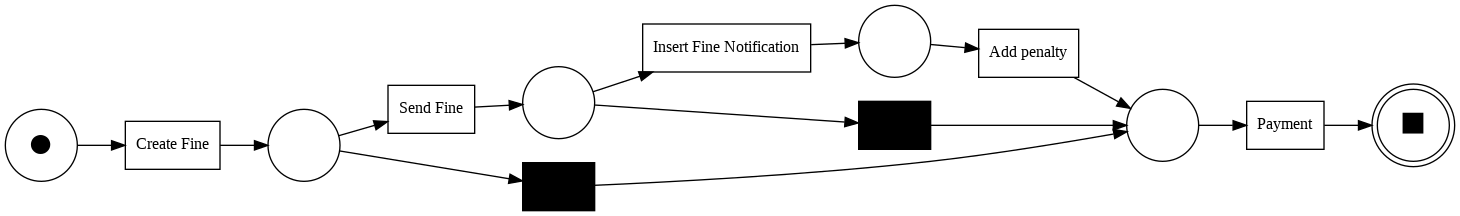

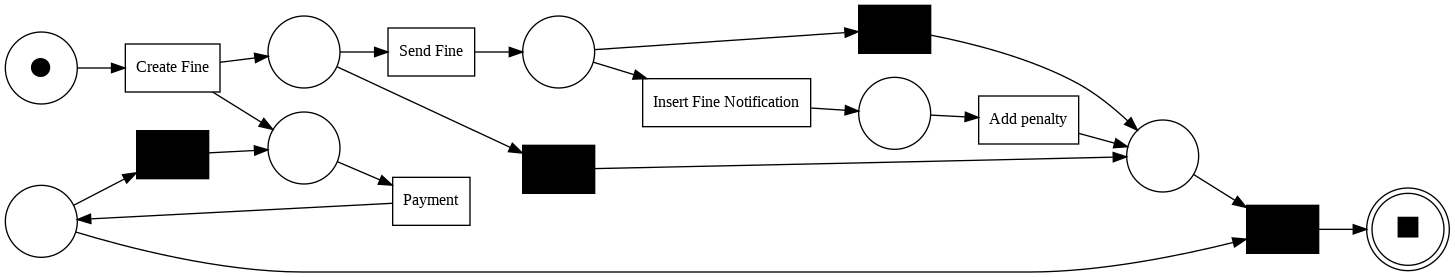

In [ ]:
net, im, fm = pm4py.discover_petri_net_heuristics(filtered_log)
pm4py.view_petri_net(net, im, fm, format='png')

net, im, fm = pm4py.discover_petri_net_inductive(filtered_log)
pm4py.view_petri_net(net, im, fm, format='png')